In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Make sure you have seaborn installed

In [10]:
from sklearn.preprocessing import StandardScaler

def data_gen(csv_file):
    # Read the CSV file and create a DataFrame
    df = pd.read_csv(csv_file)

    # Define your target variable
    target_column = 'has_parkinson'
    y = df[target_column]

    # Drop the target column and other non-essential columns if needed
    X = df.drop(columns=[target_column, 'data_group', 'event_type'])

    return [X,y]

## All features

In [41]:
from sklearn.model_selection import train_test_split

all_feature_data = data_gen('result_data.csv')
# Standardize the features
scaler = StandardScaler()
X = all_feature_data[0]
X_scaled = scaler.fit_transform(all_feature_data[0])
y = all_feature_data[1]

# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## 25 most important features using Recursive Feature Extraction

In [13]:
most_feature_data = data_gen('result_data.csv')
X_most = all_feature_data[0]
y_most = all_feature_data[1]

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# Initialize a random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Set the number of features to select
n_features_to_select = 25

# Initialize RFE with the classifier and the number of features to retain
rfe = RFE(estimator=rf_classifier, n_features_to_select=n_features_to_select)

# Fit RFE to the training data
rfe.fit(X_most, y_most)

# Get the ranking of each feature (1 means selected, 2 means not selected)
feature_ranking = rfe.ranking_

# Get the indices of the selected features
selected_features_indices = np.where(feature_ranking == 1)[0]

# Get the names of the selected features
selected_features_names = X_most.columns[selected_features_indices]

# Subset the DataFrame with selected features
X_selected = X_most[selected_features_names]

# Split the dataset into training and testing sets
X_train_most, X_test_most, y_train_most, y_test_most = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Display the selected features
print("Selected Features:")
print(selected_features_names)

Selected Features:
Index(['finish_time', 'NCV', 'relative_NCV', 'relative_NCA', 'stroke_speed',
       'velocity_median', 'velocity_std_dev', 'velocity_iqr',
       'acceleration_median', 'acceleration_std_dev', 'jerk_mean',
       'jerk_median', 'jerk_std_dev', 'velocity_x_mean', 'velocity_x_median',
       'velocity_x_std_dev', 'velocity_x_iqr', 'velocity_x_kurtosis',
       'jerk_x_mean', 'velocity_y_mean', 'velocity_y_median',
       'acceleration_y_median', 'acceleration_y_maximum', 'jerk_y_std_dev',
       'jerk_y_maximum'],
      dtype='object')


## Adaboost

In [36]:
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


def ada_boost_func(X_train,y_train,X_test,y_test):

    # Initialize an AdaBoost classifier
    n_estimators = 100
    ada_boost_clf = AdaBoostClassifier(n_estimators=n_estimators, random_state=42)

    # Train the AdaBoost classifier
    ada_boost_clf.fit(X_train, y_train)

    # Initialize arrays to store accuracy and MSE values
    train_accuracy = []
    test_accuracy = []
    train_mse = []
    test_mse = []

    # Loop through different numbers of estimators and record the accuracy and MSE
    for i, estimator in enumerate(ada_boost_clf.estimators_, 1):
        train_accuracy.append(accuracy_score(y_train, estimator.predict(X_train)))
        test_accuracy.append(accuracy_score(y_test, estimator.predict(X_test)))
        train_mse.append(mean_squared_error(y_train, estimator.predict(X_train)))
        test_mse.append(mean_squared_error(y_test, estimator.predict(X_test)))

    # Convert the lists to numpy arrays
    train_accuracy = np.array(train_accuracy)
    test_accuracy = np.array(test_accuracy)
    train_mse = np.array(train_mse)
    test_mse = np.array(test_mse)

    # Calculate accuracy and MSE for the final model
    y_train_pred = ada_boost_clf.predict(X_train)
    y_test_pred = ada_boost_clf.predict(X_test)
    final_train_accuracy = accuracy_score(y_train, y_train_pred)
    final_test_accuracy = accuracy_score(y_test, y_test_pred)
    final_train_mse = mean_squared_error(y_train, y_train_pred)
    final_test_mse = mean_squared_error(y_test, y_test_pred)

    print(f"Final Testing Accuracy: {final_test_accuracy*100}")

    # Create a line plot for both training and testing accuracy using Plotly
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=train_accuracy, mode='lines', name='Training Accuracy'))
    fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=test_accuracy, mode='lines', name='Testing Accuracy'))

    fig.update_layout(title='Training and Testing Accuracy Over Epochs',
                    xaxis_title='Number of Estimators',
                    yaxis_title='Accuracy')

    fig.show()

    # Create a line plot for both training and testing MSE loss using Plotly
    fig_mse = go.Figure()

    fig_mse.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=train_mse, mode='lines', name='Training MSE Loss'))
    fig_mse.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=test_mse, mode='lines', name='Testing MSE Loss'))

    fig_mse.update_layout(title='Training and Testing MSE Loss Over Epochs',
                        xaxis_title='Number of Estimators (Epochs)',
                        yaxis_title='MSE Loss')

    fig_mse.show()

    # Create a confusion matrix
    confusion = confusion_matrix(y_test, y_test_pred)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion, display_labels=ada_boost_clf.classes_)
    disp.plot(cmap='viridis')
    plt.title('Confusion Matrix')
    plt.show()



### all features

Final Testing Accuracy: 68.09701492537313


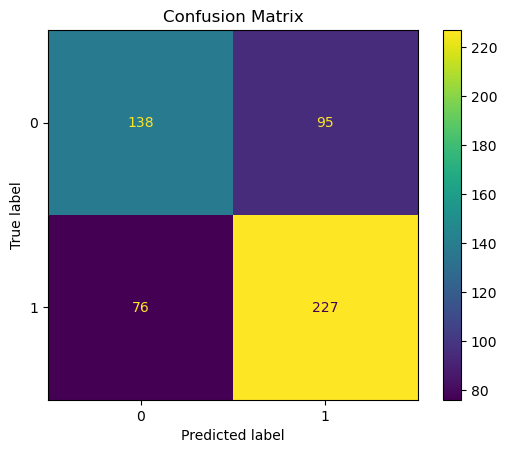

In [37]:
ada_boost_func(X_train,y_train,X_test,y_test)

### 25 features

d:\AppRelated\Anaconda\envs\mi\lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

d:\AppRelated\Anaconda\envs\mi\lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

d:\AppRelated\Anaconda\envs\mi\lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

d:\AppRelated\Anaconda\envs\mi\lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

d:\AppRelated\Anaconda\envs\mi\lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

d:\AppRelated\Anaconda\envs\mi\lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

d:\A

Final Testing Accuracy: 66.7910447761194


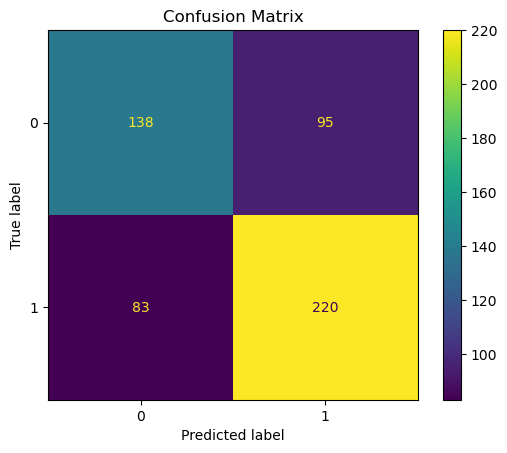

In [38]:
ada_boost_func(X_train_most,y_train_most,X_test_most,y_test_most)

In [42]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a GradientBoostingClassifier
gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Fit the GradientBoostingClassifier to the training data
gradient_boosting.fit(X_train, y_train)

# Get feature importances from the AdaBoost model
gb_feature_importances = gradient_boosting.feature_importances_

# Create a DataFrame to display feature importances
gb_importance_df = pd.DataFrame({'Column': X.columns, 'Feature Importance': gb_feature_importances})
gb_importance_df = gb_importance_df.sort_values(by='Feature Importance', ascending=False)

# Display the top N most important columns
top_n = 10  # Change this to the number of top features you want to display
top_features = gb_importance_df.head(top_n)
print(top_features)


                    Column  Feature Importance
5             stroke_speed            0.150892
0              finish_time            0.093510
4             relative_NCA            0.046491
24               jerk_mean            0.041763
1                      NCV            0.035015
70   acceleration_y_median            0.031787
44  acceleration_x_std_dev            0.029350
80          jerk_y_std_dev            0.029324
26            jerk_std_dev            0.026186
60         velocity_y_mean            0.025367


In [44]:
# Use the trained Gradient Boosting classifier to make predictions on the test data
y_pred_gb = gradient_boosting.predict(X_test)

# Calculate the accuracy of the Gradient Boosting classifier
accuracy_gb = gradient_boosting.score(X_test, y_test)

print("Accuracy (Gradient Boosting): {:.2f}%".format(accuracy_gb * 100))

Accuracy (Gradient Boosting): 68.47%


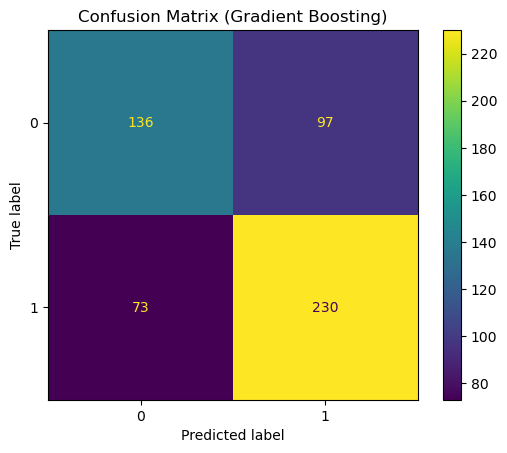

In [43]:
# Create a confusion matrix
confusion_gb = confusion_matrix(y_test, y_pred_gb)

# Plot the confusion matrix
disp_gb = ConfusionMatrixDisplay(confusion_gb, display_labels=gradient_boosting.classes_)
disp_gb.plot(cmap='viridis')
plt.title('Confusion Matrix (Gradient Boosting)')
plt.show()

d:\AppRelated\Anaconda\envs\mi\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\AppRelated\Anaconda\envs\mi\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\AppRelated\Anaconda\envs\mi\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\AppRelated\Anaconda\envs\mi\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


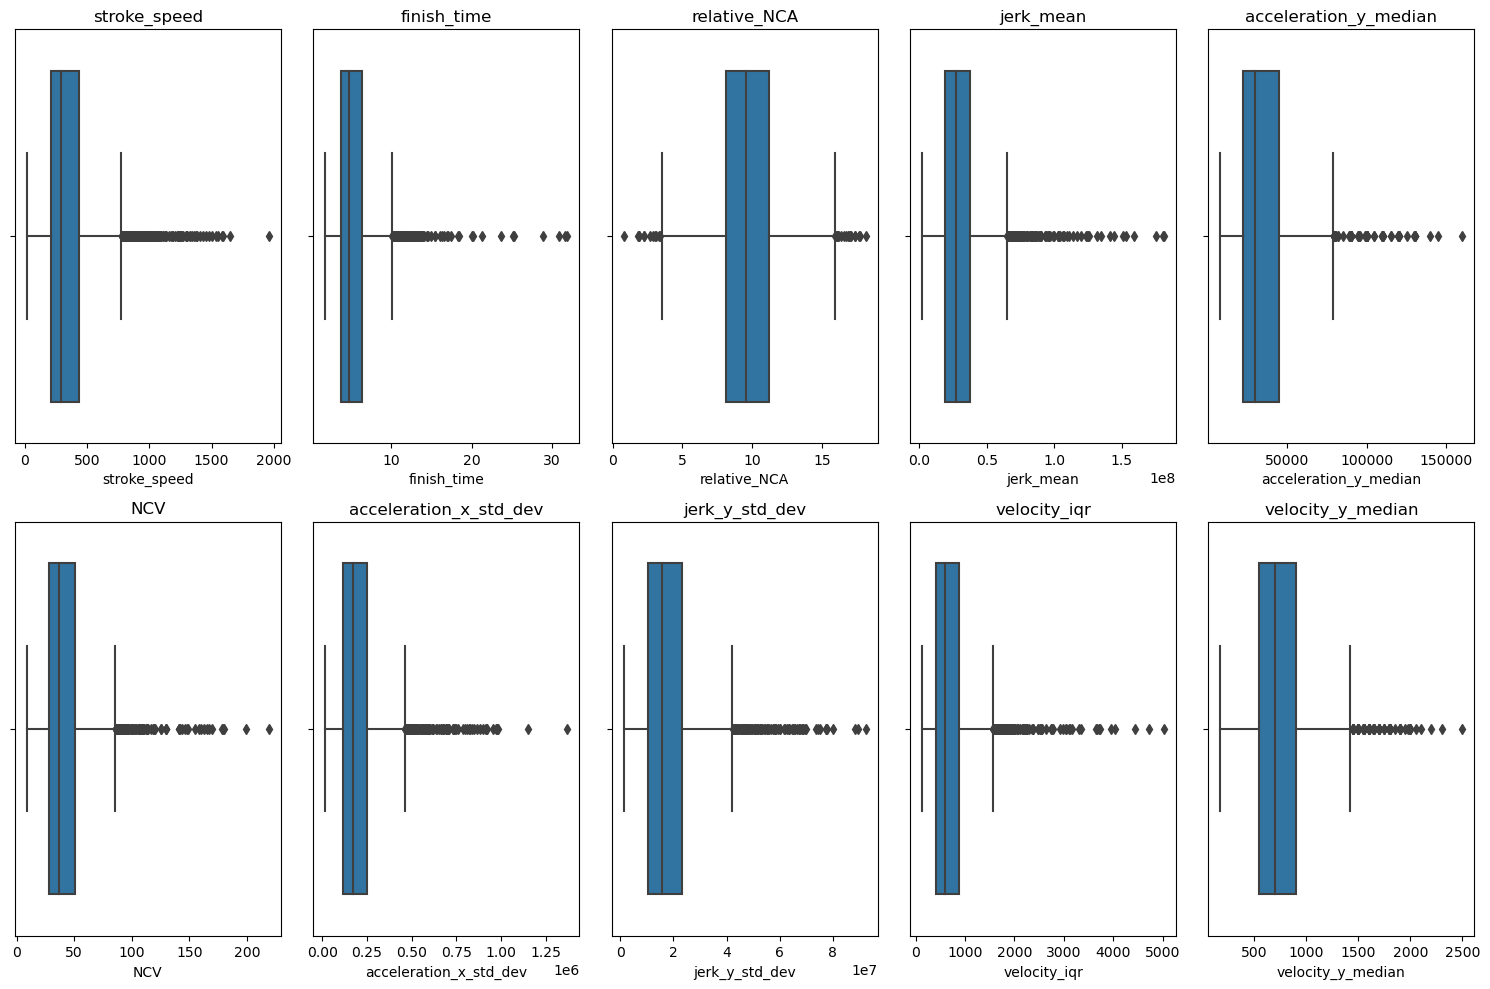

In [44]:
# Define the number of top features you want to display
top_n = 10  # Change this to the number of top features you want to visualize

# Get the top N most important features
top_features = gb_importance_df['Column'].head(top_n)

# Create larger boxplots for the top N most important columns
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Iterate through the top features and create boxplots
for i, column_name in enumerate(top_features):
    plt.subplot(2, 5, i + 1)  # Create subplots in a 2x5 grid
    sns.boxplot(data=df, x=column_name)
    plt.title(column_name)

plt.tight_layout()  # Ensure proper layout
plt.show()

## Random Forest

### All features

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, accuracy_score

# Create a RandomForestClassifier
n_estimators = 100
random_forest = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

# Lists to store training and testing losses
training_loss = []
testing_loss = []

# Lists to store training and testing accuracy
training_accuracy = []
testing_accuracy = []

# Train the Random Forest incrementally, capturing training and testing loss at each step
for i in range(1, n_estimators + 1):
    random_forest.fit(X_train[:i], y_train[:i])  # Incremental training
    
    # Calculate training accuracy
    y_pred_train = random_forest.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    # Append training accuracy to the list
    training_accuracy.append(accuracy_train)

    # Calculate training MSE
    mse_train = mean_squared_error(y_train, y_pred_train)
    # Append training MSE to the list
    training_loss.append(mse_train)
    
    # Calculate testing accuracy
    y_pred_test = random_forest.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    # Append testing accuracy to the list
    testing_accuracy.append(accuracy_test)

    # Calculate testing MSE
    mse_test = mean_squared_error(y_test, y_pred_test)
    # Append testing MSE to the list
    testing_loss.append(mse_test)
    

# random_forest_history = random_forest.fit(X_train, y_train).estimators_[0].tree_.impurity

# Fit the RandomForestClassifier to the training data
random_forest.fit(X_train, y_train)

# Get feature importances from the Random Forest model
rf_feature_importances = random_forest.feature_importances_

# Create a DataFrame to display feature importances
rf_importance_df = pd.DataFrame({'Column': X.columns, 'Feature Importance': rf_feature_importances})
rf_importance_df = rf_importance_df.sort_values(by='Feature Importance', ascending=False)

# Display the top N most important columns
top_n = 10  # Change this to the number of top features you want to display
top_features = rf_importance_df.head(top_n)
print(top_features)

                   Column  Feature Importance
5            stroke_speed            0.036593
0             finish_time            0.028083
70  acceleration_y_median            0.022992
61      velocity_y_median            0.020465
26           jerk_std_dev            0.020260
7         velocity_median            0.018271
4            relative_NCA            0.017993
39         velocity_x_iqr            0.017737
34      velocity_x_median            0.017101
24              jerk_mean            0.017098


In [46]:
# Use the trained Random Forest classifier to make predictions on the test data
y_pred_rf = random_forest.predict(X_test)

# Calculate the accuracy of the Random Forest classifier
accuracy_rf = random_forest.score(X_test, y_test)

print("Accuracy (Random Forest): {:.2f}%".format(accuracy_rf * 100))

Accuracy (Random Forest): 71.46%


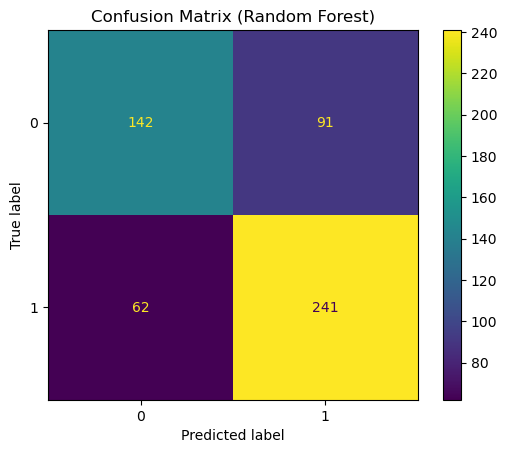

In [47]:
# Create a confusion matrix
confusion_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix 
disp_rf = ConfusionMatrixDisplay(confusion_rf, display_labels=random_forest.classes_)
disp_rf.plot(cmap='viridis')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

In [49]:
import plotly.graph_objects as go

# Create a line plot for both training and testing MSE using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=training_loss, mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=testing_loss, mode='lines', name='Testing Loss'))

fig.update_layout(title='Training and Testing Loss Over Epochs',
                  xaxis_title='Number of Estimators (Epochs)',
                  yaxis_title='MSE')

fig.show()


In [50]:
# Create a line plot for both training and testing accuracy using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=training_accuracy, mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=testing_accuracy, mode='lines', name='Testing Accuracy'))

fig.update_layout(title='Training and Testing Accuracy Over Epochs',
                  xaxis_title='Number of Estimators (Epochs)',
                  yaxis_title='Accuracy')

fig.show()

### 25 features with Recursive Feature Extraction

In [59]:
# Create a RandomForestClassifier
n_estimators = 100
random_forest_most = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

# Lists to store training and testing losses
training_loss = []
testing_loss = []

# Lists to store training and testing accuracy
training_accuracy = []
testing_accuracy = []

# Train the Random Forest incrementally, capturing training and testing loss at each step
for i in range(1, n_estimators + 1):
    random_forest_most.fit(X_train_most[:i], y_train_most[:i])  # Incremental training
    
    # Calculate training accuracy
    y_pred_train = random_forest_most.predict(X_train_most)
    accuracy_train = accuracy_score(y_train_most, y_pred_train)
    # Append training accuracy to the list
    training_accuracy.append(accuracy_train)

    # Calculate training MSE
    mse_train = mean_squared_error(y_train, y_pred_train)
    # Append training MSE to the list
    training_loss.append(mse_train)
    
    # Calculate testing accuracy
    y_pred_test = random_forest_most.predict(X_test_most)
    accuracy_test = accuracy_score(y_test_most, y_pred_test)
    # Append testing accuracy to the list
    testing_accuracy.append(accuracy_test)

    # Calculate testing MSE
    mse_test = mean_squared_error(y_test_most, y_pred_test)
    # Append testing MSE to the list
    testing_loss.append(mse_test)
    

# random_forest_history = random_forest.fit(X_train, y_train).estimators_[0].tree_.impurity

# Fit the RandomForestClassifier to the training data
random_forest_most.fit(X_train_most, y_train_most)

RandomForestClassifier(random_state=42)

In [60]:
# Use the trained Random Forest classifier to make predictions on the test data
y_pred_rf = random_forest_most.predict(X_test_most)

# Calculate the accuracy of the Random Forest classifier
accuracy_rf = random_forest_most.score(X_test_most, y_test_most)

print("Accuracy (Random Forest): {:.2f}%".format(accuracy_rf * 100))

Accuracy (Random Forest): 72.39%


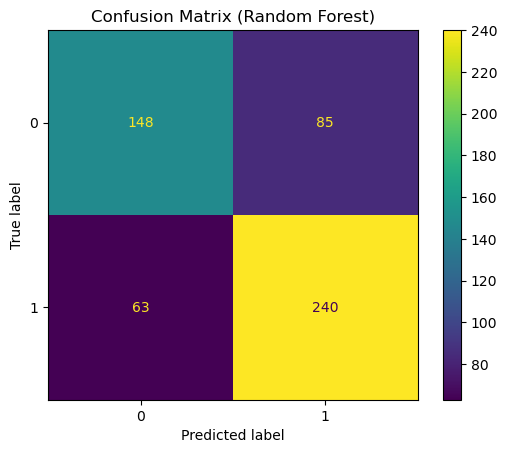

In [61]:
import plotly.graph_objects as go

# Create a confusion matrix
confusion_rf = confusion_matrix(y_test_most, y_pred_rf)

# Plot the confusion matrix 
disp_rf = ConfusionMatrixDisplay(confusion_rf, display_labels=random_forest.classes_)
disp_rf.plot(cmap='viridis')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# Create a line plot for both training and testing MSE using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=training_loss, mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=testing_loss, mode='lines', name='Testing Loss'))

fig.update_layout(title='Training and Testing Loss Over Epochs',
                  xaxis_title='Number of Estimators (Epochs)',
                  yaxis_title='MSE')

fig.show()

# Create a line plot for both training and testing accuracy using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=training_accuracy, mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=np.arange(1, n_estimators + 1), y=testing_accuracy, mode='lines', name='Testing Accuracy'))

fig.update_layout(title='Training and Testing Accuracy Over Epochs',
                  xaxis_title='Number of Estimators (Epochs)',
                  yaxis_title='Accuracy')

fig.show()